In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os

from scipy import *
from math import *
import pandas as pd

import datetime as dt

import scipy.stats
deb = dt.datetime(1899,12,30)
import time

### Import the data. 

Each line of this dataframe contains for each parcel:
- the identity number of the parcel (Id_parcel), 
- the date when the parcel is ready for expedition (DateR), 
- the date when the parcel is taken over by a carrier (DateE), 
- the delivery date (DateD), 
- the pick up date (DateP),
- the carrier (Carrier).


In [2]:
tdata = pd.read_csv('data.csv',sep = ',')

Convert the type of the date columns from string to datetime 


In [3]:
tdata['DateR'] = pd.to_datetime(tdata['DateR'])
tdata['DateE'] = pd.to_datetime(tdata['DateE'])
tdata['DateD'] = pd.to_datetime(tdata['DateD'])
tdata['DateP'] = pd.to_datetime(tdata['DateP'])

In [4]:
tdata

,Id_parcel,DateR,DateE,DateD,DateP
0,1,2017-01-02,2017-01-02 15:51:00,2017-01-03 09:05:55,2017-01-05 18:21:36
1,2,2017-01-02,2017-01-02 16:19:00,2017-01-03 09:06:23,2017-01-05 07:54:31
2,3,2017-01-02,2017-01-02 22:22:00,2017-01-03 09:06:54,2017-01-03 18:20:29
3,4,2017-01-02,2017-01-02 17:47:58,2017-01-04 08:49:24,2017-01-04 16:03:37
4,5,2017-01-02,2017-01-03 15:12:00,2017-01-04 09:05:09,2017-01-04 17:22:15
...,...,...,...,...,...
16890,16891,2019-12-30,2019-12-30 18:33:06,2019-12-31 09:23:03,2020-01-14 06:00:00
16891,16892,2019-12-30,2019-12-30 15:48:57,2019-12-31 11:14:01,2019-12-31 16:45:14
16892,16893,2019-12-30,2019-12-30 19:40:00,2019-12-31 09:22:56,2020-01-14 06:00:00
16893,16894,2019-12-30,2019-12-30 19:34:00,2019-12-31 09:22:44,2019-12-31 16:32:06


Create the list of all the 1-day time intervals from 1/1/2017 00:00 to 31/12/2019 23:59, e.g. the value dt.date(2017,1,1) indicates the time interval between 1/1/2017 00:00 and 1/1/2017 23:59

In [5]:
#list of the dates
dateR = tdata['DateR']
dateE = tdata['DateE']
dateD = tdata['DateD']
dateP = tdata['DateP']


list_dates = [dt.date(2017,1,1)]
while list_dates[-1]<dt.date(2019,12,31):
    list_dates.append(list_dates[-1]+dt.timedelta(days = 1))

This function computes the moving average of a time series, with inputs:
- list_parcels: the time series
- scale: the size of the subsequence to compute the average

In [6]:
def moving_average(list_parcels,scale):
    m_a = []
    for i in range(len(list_parcels)-int(scale)):
        m_a.append(np.mean(list_parcels[i:i+scale]))
    return(m_a)

Create the list of all the 1-hour time intervals from 1/1/2017 00:00 to 31/12/2019 23:59, e.g. the value dt.datetime(2017,1,1,0,0) indicates the time interval between 1/1/2017 00:00 and 1/1/2017 00:59. 

In [7]:
list_datetime = [dt.datetime(2017,1,1,0)]
while list_datetime[-1]<dt.datetime(2019,12,31,23):
    list_datetime.append(list_datetime[-1]+dt.timedelta(hours = 1))

Converting the date of each step into the time interval, e.g., if the parcel is delivered at 2/1/2017 10:49 the delivery interval will be 2/1/2017 10:00

In [8]:
tR = dateR.copy()
tE = dateE.copy()
tD = dateD.copy()
tP = dateP.copy()
for i in range(len(dateR)):
    if type(dateR[i]) == pd._libs.tslibs.timestamps.Timestamp:
        tR[i] = dt.datetime.combine(dateR[i].date(),dt.time(dateR[i].hour))
    if type(dateE[i]) == pd._libs.tslibs.timestamps.Timestamp:
        tE[i] = dt.datetime.combine(dateE[i].date(),dt.time(dateE[i].hour))
    if type(dateD[i]) == pd._libs.tslibs.timestamps.Timestamp:
        tD[i] = dt.datetime.combine(dateD[i].date(),dt.time(dateD[i].hour))
    if type(dateP[i]) == pd._libs.tslibs.timestamps.Timestamp:
        tP[i] = dt.datetime.combine(dateP[i].date(),dt.time(dateP[i].hour))

In [9]:
dateR = tR.copy()
dateE = tE.copy()
dateD = tD.copy()
dateP = tP.copy()

### Compute the number of parcels delivered, the number of parcels picked up during each 1-hour time interval

$s_\text{max}$ is the maximum number of days that a parcel waits for being picked up in PUP. Once those s_max days are over, the parcel will be returned to the e-shop. 

For each 1-hour time interval $t$, firstly, count the number of delivered parcels $D\left(i,h\right)$

For each 1-hour time interval $t$ and for each sojourn duration $s=0,...,s_\text{max}$, count $P\left(i,h,s\right)$ the number of parcels picked up during the time interval $t$ and that have been stayed in the PUP for $s$ days since the delivery date. For each parcel picked-up, the value of $s$ is the difference between the calendar date of the pick up date and the calendar date of delivery.

At the beginning of each 1-hour time interval $t$ and for each sojourn duration $s=0,...,s_\text{max}$, compute the load of the PUP, i.e. the number of parcels in the PUP at the end of the interval with a sojourn duration $s$ with, for $s=0$: 
$$L\left(i,h,0\right)=L\left(i,h-1,0\right)+D\left(i,h-1\right)-P\left(i,h-1,0\right)$$ 
and for s>0:
$$L\left(i,h,s\right)=L\left(i,h-1,s\right)-P\left(i,h-1,s\right)$$

We choose a random value for the initual load of the PUP, that is the load of the PUP at time 1-1-2017 00:00. E.g.: initially, there is 5 parcels that have been stayed for 1 day, 5 parcels for 2 days, 3 parcels for 3 days, and so on.

At the beginning of each day, the load of PUP is updated depending on $s$:
$$L\left(i,h_{\text{o}}\left(i\right),0\right)=0$$
and 
$$L\left(i,h_{\text{o}}\left(i\right),s\right)=L\left(i-1,h_{\text{c}}\left(i-1\right),s-1\right)$$
with $h_{\text{o}} = 0$. 
We assume that at the end of the $s_\text{max}$th day, the parcel that still have not been picked up yet will be returned to the e-shop, so is removed from the load of PUP. 

In [10]:

#Computing the load at the end of each time interval

s_max = 14 #maximum days that a parcel can stay in the PUP after delivery


nb_deliveries_h_s = np.zeros((len(list_datetime)*(s_max+1)))
nb_pickedup_h_s = np.zeros((len(list_datetime)*(s_max+1)))
list_datetime_s = []

for i in range(len(list_datetime)):
    datei = list_datetime[i]
    for s in range(s_max+1):
        list_datetime_s.append(datei)
    ind_datei_delivery = dateD.index[dateD==datei]
    nb_deliveries_h_s[i*(s_max+1)]+=len(ind_datei_delivery)
    #list_datetime_s[i*(s_max+1)] = 3

    ind_datei_picked_up = dateP.index[dateP == datei]
    for idx in ind_datei_picked_up:
        if type(dateD[idx]) == pd._libs.tslibs.timestamps.Timestamp:
            s = (dateP[idx].date()-dateD[idx].date()).days
            nb_pickedup_h_s[i*(s_max+1)+int(s)]+=1

#load at the end of day 31-12-2016 (random value)
#corresponding to the sojourn days s=0,...,s_max        
initial_load = [0,5, 5, 3, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0] 

load_h_s = np.zeros((len(list_datetime)*(s_max+1)))
for i in range(0,len(nb_deliveries_h_s),s_max+1):
    load_h_s[i:i+s_max+1]=initial_load+nb_deliveries_h_s[i:i+s_max+1]-nb_pickedup_h_s[i:i+s_max+1]
    initial_load = load_h_s[i:i+s_max+1].copy()
    if list_datetime_s[i].hour == 23:
        initial_load = list(initial_load)
        initial_load = [0]+initial_load
        initial_load.pop()




- load_13: the load of the PUP at 13:00 of each day $L(i,13)$
- nb_deliveries: number of daily delivered parcels $D(i)$
- nb_pickedup: number of daily picked-up parcels $P(i)$

In [11]:
load_13 = []
for i in range(0, len(load_h_s),24*15):
    load_13.append(np.sum(load_h_s[i+12*15:i+13*15]))        
    
nb_deliveries = []
for i in range(0,len(nb_deliveries_h_s),15*24):
    nb_deliveries.append(np.sum(nb_deliveries_h_s[i:i+15*24]))
    

nb_pickedup = []
for i in range(0,len(nb_deliveries_h_s),15*24):
    nb_pickedup.append(np.sum(nb_pickedup_h_s[i:i+15*24]))

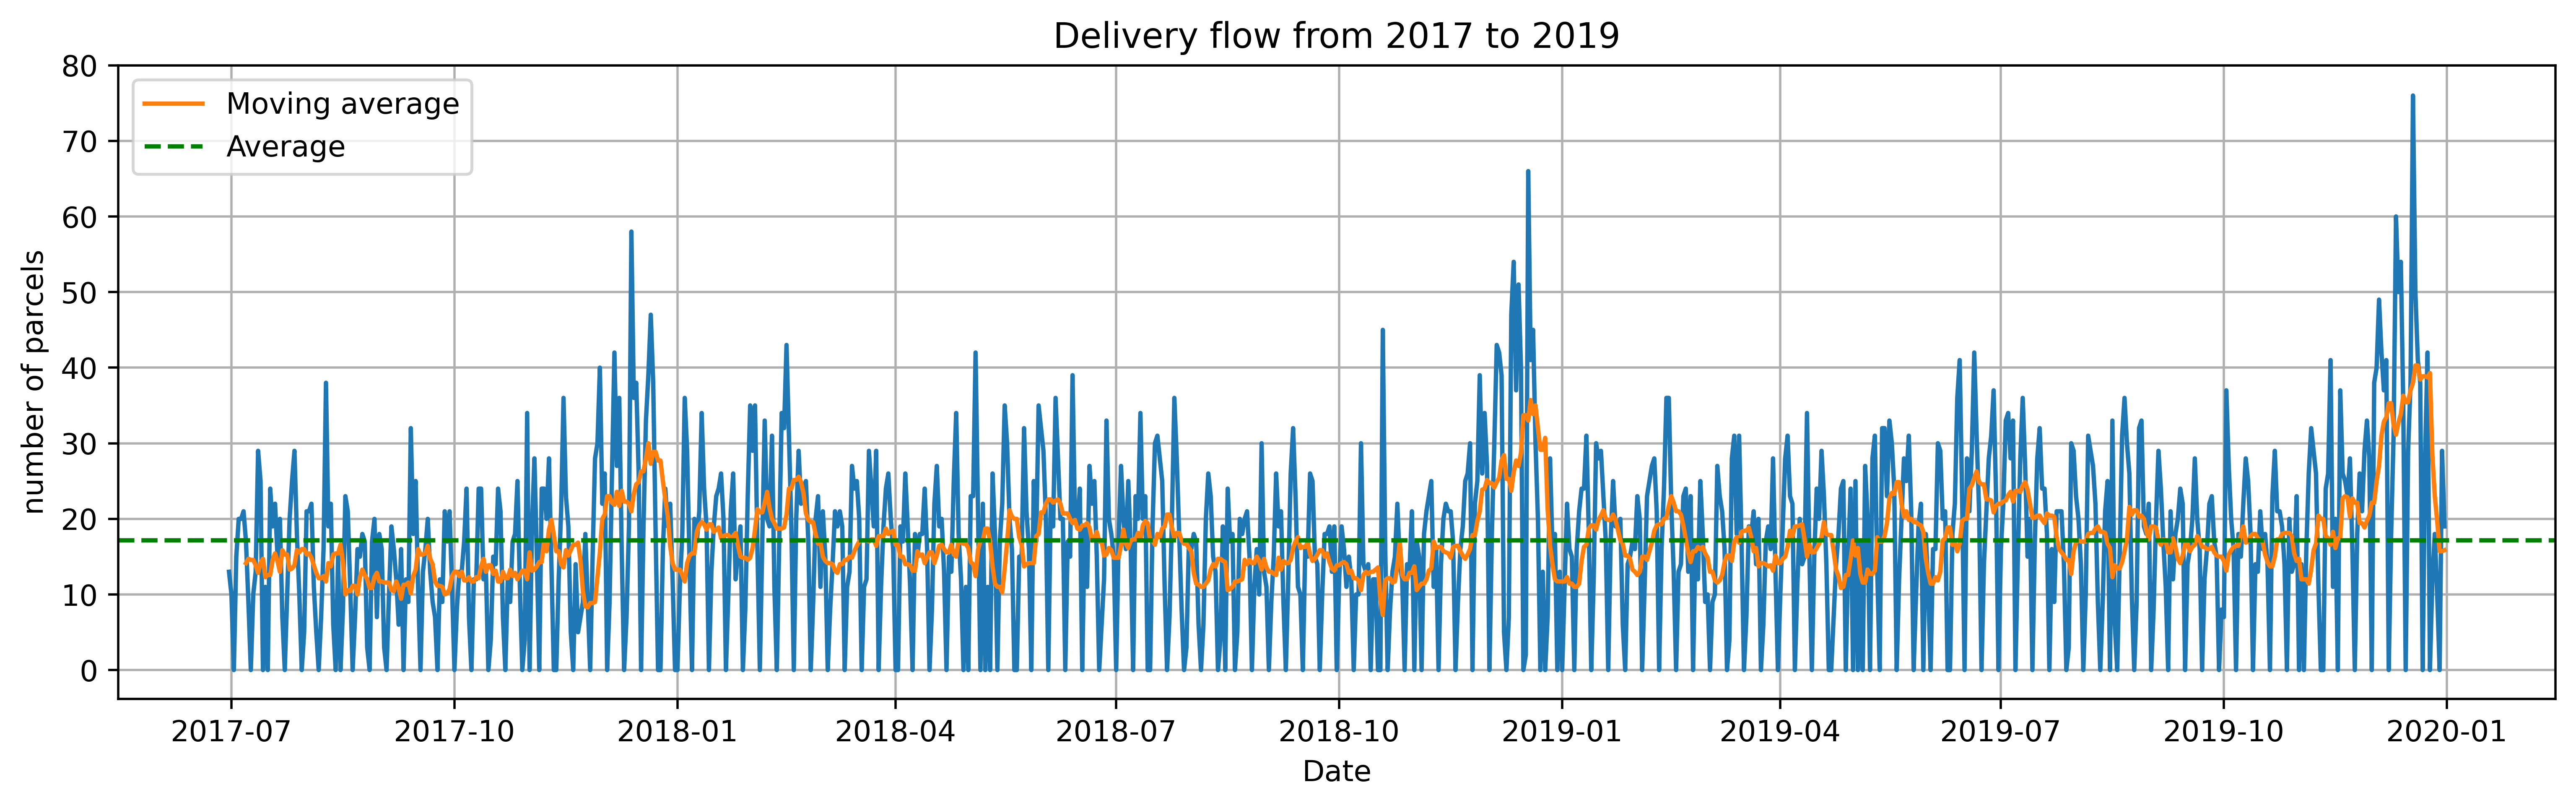

In [12]:
plt.figure(figsize=(15,4),dpi = 500)
plt.plot(list_dates[180:],nb_deliveries[180:])
plt.plot(list_dates[180+7:],moving_average(nb_deliveries[180:],7),label = 'Moving average')
plt.grid()
plt.axhline(np.mean(nb_deliveries[180:]),linestyle = '--',color = 'green',label = 'Average')
plt.ylim(ymax = 80)
plt.title("Delivery flow from 2017 to 2019")
plt.ylabel('number of parcels')
plt.xlabel('Date')
plt.legend(loc = 'best')


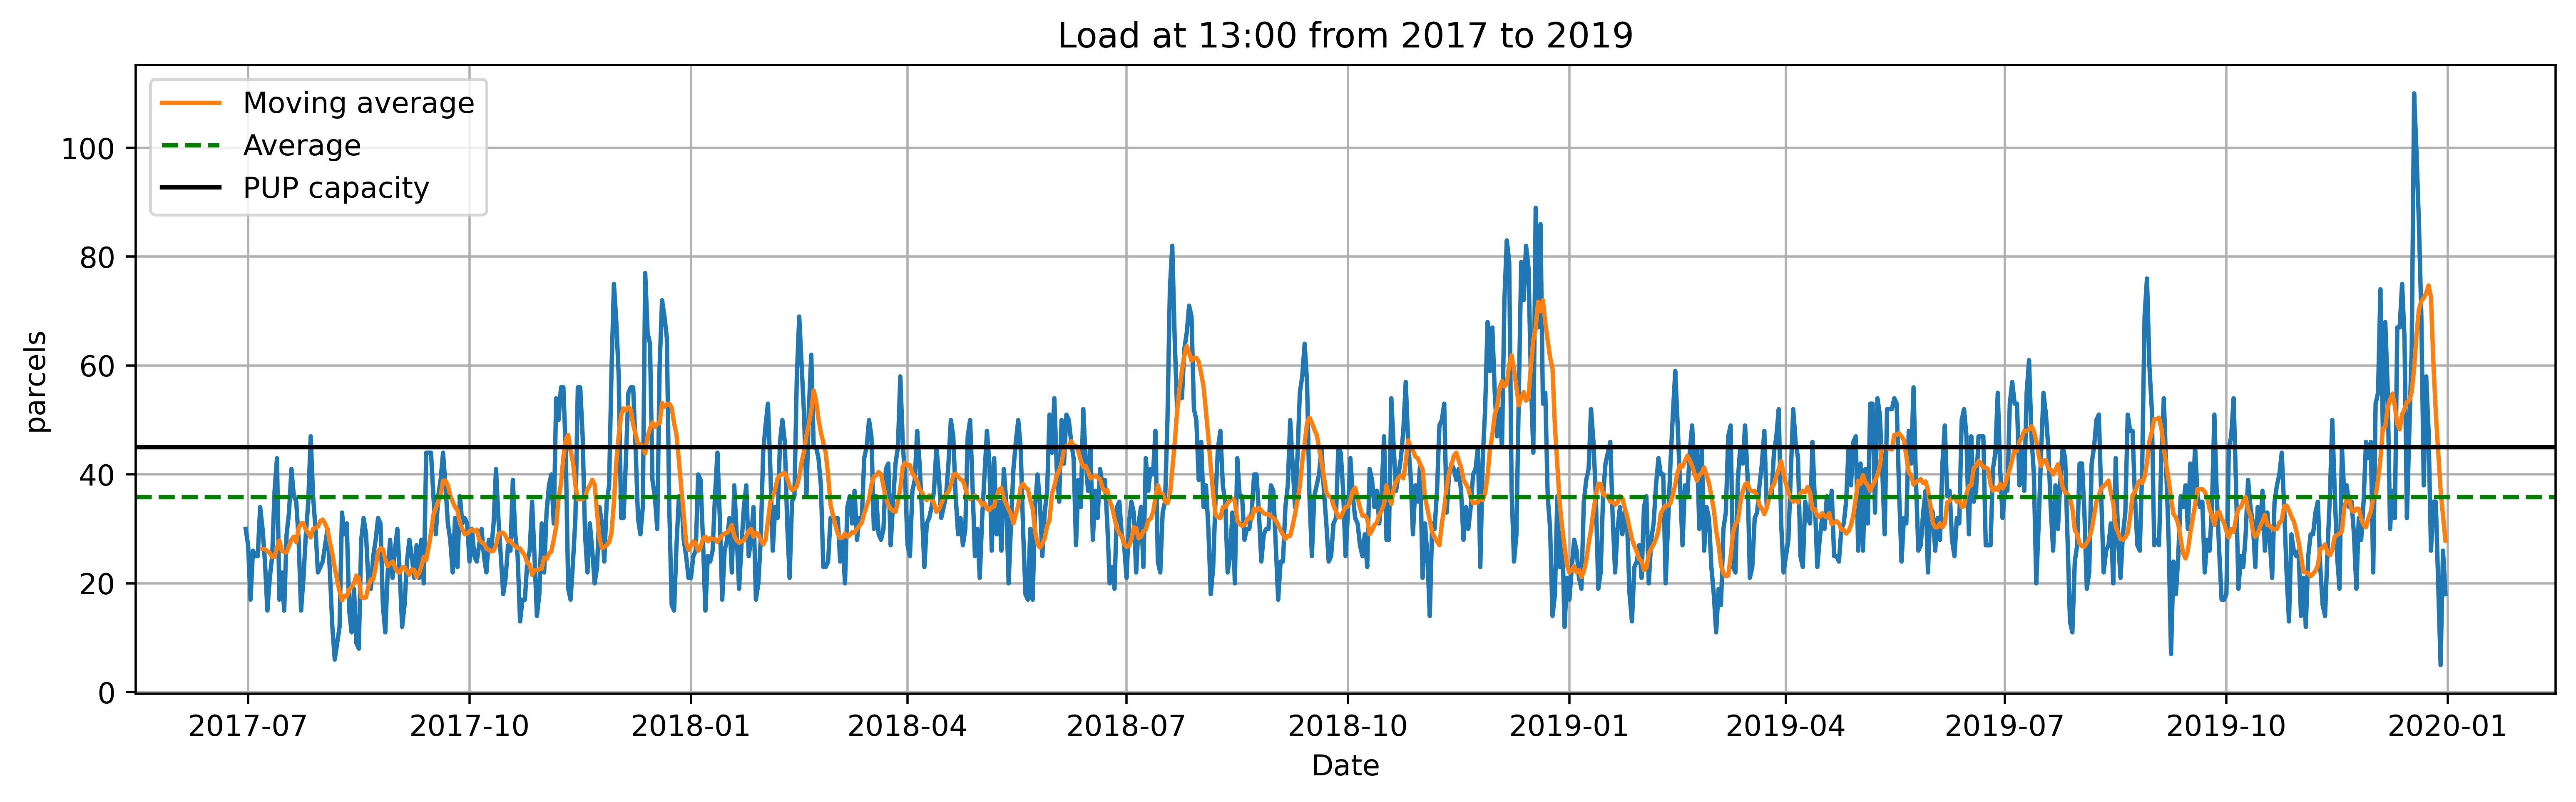

In [13]:
plt.figure(figsize=(15,4),dpi = 500)
plt.plot(list_dates[180:],load_13[180:])
plt.plot(list_dates[180+7:],moving_average(load_13[180:],7),label = 'Moving average')
plt.grid()
plt.axhline(np.mean(load_13[180:]),linestyle = '--',color = 'green',label = 'Average')
plt.axhline(y = 45,label = 'PUP capacity',color = 'black')
plt.title("Load at 13:00 from 2017 to 2019")
plt.ylabel('parcels')
plt.xlabel('Date')
plt.legend(loc = 'best')